# Primjena tehnika smanjenja dimenzije podataka u klasifikaciji peludi

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from scipy.spatial import distance_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt

Učitavanje podataka

In [2]:
data=pd.read_excel("./pollen.xlsx")
data.head

<bound method NDFrame.head of                     Pollen Type                Time  Feature 1  Feature 2  \
0         Urtica Diocia (Plair) 2018-12-06 14:59:00         14         38   
1         Urtica Diocia (Plair) 2018-12-06 14:59:00         -5        -21   
2         Urtica Diocia (Plair) 2018-12-06 14:59:00         56         33   
3         Urtica Diocia (Plair) 2018-12-06 14:59:00         26         46   
4         Urtica Diocia (Plair) 2018-12-06 14:59:00         38         13   
...                         ...                 ...        ...        ...   
24112  Ambrosia Artemisifolia 2 2018-12-06 15:08:00         23         -1   
24113  Ambrosia Artemisifolia 2 2018-12-06 15:08:00         66         52   
24114  Ambrosia Artemisifolia 2 2018-12-06 15:08:00         12         35   
24115  Ambrosia Artemisifolia 2 2018-12-06 15:08:00         62         56   
24116  Ambrosia Artemisifolia 2 2018-12-06 15:08:00         50         35   

       Feature 3  Feature 4  Feature 5  Featu

In [4]:
X1 = data.drop(['Pollen Type','Time'], axis=1)
scaler = StandardScaler()
scaler.fit(X1)
X1 = scaler.transform(X1)

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, data[['Pollen Type']], test_size=0.30, random_state=42)

y1_train, y1_test = y1_train.to_numpy(), y1_test.to_numpy()

In [5]:
print("Trening podaci: X= ", X1_train.shape)
print("Trening podaci: y= ", y1_train.shape)
print("Test podaci: X= ", X1_test.shape)
print("Test podaci: y= ", y1_test.shape)

Trening podaci: X=  (16881, 608)
Trening podaci: y=  (16881, 1)
Test podaci: X=  (7236, 608)
Test podaci: y=  (7236, 1)


## 1. Analiza glavnih komponenti - PCA

Podaci nam govore o klasifikaciji peludi. Mogu se podijeliti u 16 vrsta.

Zbog velike dimenzije podataka, i za treniranje, i za testiranje, primjenit ću na njih metodu za smanjivanje dimenzije. 

In [50]:
class impl_PCA():
    def _init_(self): 
        self.components= None
        self.mean= None
        
    def get_k(self,X):
        cov_mat = np.cov(X.T)
        eig_vals, _ = np.linalg.eig(cov_mat)
        eig_vals[::-1].sort()
        cummulative_variance = 0
        for i,lam in enumerate(eig_vals):
            cummulative_variance+= (lam/sum(eig_vals))
            plt.scatter(i,cummulative_variance)
            if cummulative_variance==0.9:         # želim da ostane sačuvano oko 90 posto varijance
                self.n_components=i
        
    def fit(self, X, k):
        # centralizacija podataka
        self.mean=np.mean(X,axis=0)       
        X=X-self.mean
        
        # kovarijacijska matrica
        cov_mat = np.cov(X.T)
        
        # svojstvene vrijednosti i svojstveni vektori
        eig_vals, eig_vecs = np.linalg.eig(cov_mat)
        
        # sortiranje svojstvenih vrijednosti                   
        eig_vecs=eig_vecs.T
        eig_vecs=eig_vecs[:,np.argsort(eig_vals)[::-1]]
        
        # spremanje prvih k elemenata matrice s kojom će se množiti podaci
        self.components=eig_vecs[0:k]
        
    def transform(self, X):
        X=X-self.mean
        return np.dot(X,self.components.T)

In [62]:
PCA=impl_PCA()
PCA2=impl_PCA()

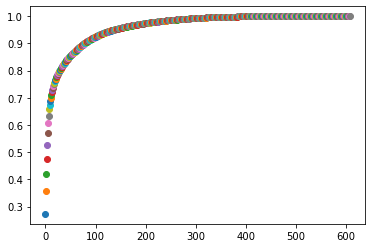

In [63]:
PCA.get_k(X1_train)   #Služi da vidimo koje bi k bilo najbolje uzeti

In [64]:
PCA.fit(X1_train,k=400)     # Uočavamo da za k=400 imamo sačuvano približno 100% varijanci, dakle za k odabirem 400
PCA2.fit(X1_test,k=400)

In [65]:
T=PCA.transform(X1_train)   # Ovdje se smanjuje dimenzija
Tt=PCA2.transform(X1_test)

In [66]:
print(T.shape)
print(X1_train.shape)
print(Tt.shape)

(16881, 400)
(16881, 608)
(7236, 400)


Model - koristit ću gotovu Logističku Regresiju iz sclearn-a.

Prvo ću ga pozvati na nepromijenjenim podacima, a nakon toga na promijenjenim.

Računanjem točnosti, kod oba slučaja, želim vidjeti kolika je razlika.

In [67]:
lg11=LogisticRegression(random_state=0,max_iter=4000).fit(X1_train,y1_train.ravel())

In [68]:
A=accuracy_score(y1_test,lg11.predict(X1_test))
print("Accuracy_score je kod podataka nepromijenjene dimenzije bio: ")
print(A)

Accuracy_score je kod podataka nepromijenjene dimenzije bio: 
0.5179657269209508


In [69]:
print(T.shape)
print(y1_train.shape)

(16881, 400)
(16881, 1)


In [70]:
lg12=LogisticRegression(random_state=0,max_iter=4000).fit(T[:,:],y1_train.ravel())

In [71]:
accuracy_score(y1_test,lg12.predict(Tt))

0.15865118850193477

### Zaključak

Smanjivanjem dimenzije morali smo paziti da ne izgubimo veliki broj svojstava i zato smo za dimenziju k, odabrali onakav k za koji je ostalo sačuvano približno 100% varijance. Inače se zna uzeti i da bude sačuvano 90% varijance. 

U mjerenju točnosti mogli smo vidjeti da je točnost jako loša i razlika je velika.

## 2. Analiza nezavisnih komponenti - ICA  

Koristit ću iste podatke koje sam koristila kod PCA metode.


In [51]:
class impl_ICA():
    def __init__(self):
        self.T= None
        
    def fit(self, X, d, iteracija=2, razlika1=10000, step_size=1):
        #određivanje veličina
        m,n=X.shape
        #broj_klasa=np.unique(y).shape[0]
        
        # random uzimanje prvih težina T
        self.T=np.random.rand(d,m)           #za m*m mi je ispisalo da nema mjesta za 2.1GB memorije
        
        #iteriramo i za svaki iz težina T treba napraviti sljedeće
        for kl in range(d):
            t=self.T[kl,:].copy().reshape(m,1)
            t = t / np.linalg.norm(t)       # ili np.sqrt((t ** 2).sum())
            
            #dodatna vrijednost s kojom se pazi da je petlja ograničena
            i=0;
            
            #zadajemo broj iteracija i razliku da znamo kada treba stati
            while(i<iteracija):

                t1= X*(np.tanh(t.T.dot(X)*step_size))
                t2= (1 - np.square(np.tanh(t.T.dot(X))))*step_size
                t3= t1.mean(axis=1) - t2.mean() * np.squeeze(t)  #t3 su sad nove težine
                
                #print(t3.shape)
                #normalizacija i tkzv. dekorelacija - zbog njega dobivene vrijednosti su različite
                t3= t3 - np.dot(np.dot(t3, self.T[:kl].T), self.T[:kl])
                t3= t3 / np.linalg.norm(t3)                        #ili np.sqrt((t3 ** 2).sum())   
                
                
                #još jedan uvjet za stajanje je da je razlika između veličina dviju iteracija već jako mala
                razlika= np.abs(np.abs((t3*t).sum())-1)
                t= t3
                if razlika < razlika1:
                    break
                
                i=i+1
            self.T[kl,:]= t.T           
        
    
    def transform(self, X):
        return np.dot(X.T,self.T.T)

In [73]:
ICA=impl_ICA()
ICA2=impl_ICA()

In [75]:
ICA.fit(X1_train, d=100)   
ICA2.fit(X1_test, d=100)

In [56]:
I=ICA.transform(X1_train)
It=ICA2.transform(X1_test)

In [57]:
print(I.shape)
print(y1_train.shape)

(608, 100)
(16881, 1)


Model - koristit ću gotovu Logističku Regresiju iz sclearn-a.

Prvo ću ga pozvati na nepromijenjenim podacima, a nakon toga na promijenjenim.

Računanjem točnosti kod oba slučaja, želim vidjeti ima li, i ako ima, kolika je razlika.

In [74]:
print("Accuracy_score je kod podataka nepromijenjene dimenzije bio: ")
print(A)

Accuracy_score je kod podataka nepromijenjene dimenzije bio: 
0.5179657269209508


In [59]:
lg22=LogisticRegression(random_state=0,max_iter=4000).fit(I[:,:],y1_train[:I.shape[0]].ravel())

C:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [76]:
accuracy_score(y1_test[:I.shape[0]],lg22.predict(It))

0.14473684210526316

### Zaključak

Računanjem težina sve dok, ili razlika između njih ne postane jako mala ili napravimo unaprijed zadan veliki broj iteracija, dolazimo do matrice s kojom će se množiti naši podaci.

Točnost se jako smanjila. Velika je razlika.

# 3. Metoda slučajne projekcije - RP

Koristit ću podatke koje sam koristila i kod PCA metode.

In [6]:
class impl_RP():
    def __init__(self):
        self.R=None
        
    def fit(self, X, d):  # d je željena veličina na koju želimo reducirati
        m,n = X.shape
        
        #random matrica s težinama
        self.R=np.random.rand(n,d)  
        
        #normalizacija
        self.R=normalize(self.R, norm='l2')   # ili R = R / np.linalg.norm(R)
        
    def transform(self,X):
        return np.dot(X,self.R)

In [78]:
RP=impl_RP()
RP2=impl_RP()

In [79]:
RP.fit(X1_train, d=400)   
RP2.fit(X1_test, d=400)

In [80]:
R= RP.transform(X1_train)
Rt= RP2.transform(X1_test)

In [81]:
print(R.shape)
print(y1_train.shape)

(16881, 400)
(16881, 1)


Model - koristit ću gotovu Logističku Regresiju iz sclearn-a. 

In [82]:
print("Accuracy_score kod podataka nepromijenjene dimenzije bio: ")
print(A)

Accuracy_score kod podataka nepromijenjene dimenzije bio: 
0.5179657269209508


In [83]:
lg32=LogisticRegression(random_state=0,max_iter=5000).fit(R[:,:],y1_train.ravel())

C:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [84]:
accuracy_score(y1_test,lg32.predict(Rt))

0.22291321171918188

### Zaključak

Smanjivanje dimenzije na način da se matrica s random odabranim težinama normalizira dala je loše rezultate.

Velika je razlika u točnosti kod promjenjenih i kod nepromijenjenih podataka.

# 4. Višedimenzionalno skaliranje - MDS

Unutar višedimenzionalnog skaliranja postoji više metoda za različite vrste podataka. Klasičan MDS (cMDS) je isto podvrsta MDS-a i njega ću implementirati.

In [55]:
class impl_cMDS():
    def __init__(self):
        self.M=None
        self.M2=None
        
    def fit(self, X, d):    # d je broj na koji se samnjuje

        # matrica udaljenosti mu treba za daljnje računanje
        # mora biti pozvano na simetričnoj matrici
        m=X.shape[0]
        
        #centriranje
        cent_matrica = np.identity(m) -(1/m)*np.ones((m,m))
        
        #računanje kovarijacijske matrice
        cov_mat = -(1/2)*cent_matrica.dot(X**2).dot(cent_matrica)
        
        # svojstvene vrijednosti i svojstveni vektori
        eig_vals, eig_vecs = np.linalg.eig(cov_mat)
        
        # sortiranje svojstvenih vrijednosti                   
        eig_vecs=eig_vecs[:,np.argsort(eig_vals)[::-1]]
        eig_vals=eig_vals[np.argsort(eig_vals)[::-1]]
        
        #dobivanje korijena od produkta svojstvenih vektora i dijagonalne metrike svojstvenih vrijednosti
        self.M=np.diag(np.sqrt(abs(eig_vals[:d])))
        self.M2=eig_vecs[:,:d]
        
        #Uzimanje samo realnih vrijednosti
        self.M=self.M.real
        self.M2=self.M2.real
        
    def transform(self):
        return np.transpose(np.dot(self.M, np.transpose(self.M2)))

In [119]:
cMDS=impl_cMDS()
cMDS2=impl_cMDS()

In [ ]:
cMDS.fit(pairwise_distances(X1_train),d=100)
cMDS2.fit(pairwise_distances(X1_test),d=100)

In [100]:
M= cMDS.transform()   #smanjivanje dimenzije
Mt= cMDS2.transform()

Model - koristit ću gotovu Logističku Regresiju iz sclearn-a. 

In [102]:
print("Accuracy_score je kod podataka nepromijenjene dimenzije bio: ")
print(A)

Accuracy_score je kod podataka nepromijenjene dimenzije bio: 
0.5179657269209508


In [103]:
lg42=LogisticRegression(random_state=0,max_iter=1000).fit(M,y1_train.ravel())

In [104]:
accuracy_score(y1_test,lg42.predict(Mt))

0.37797125483692645

### Zaključak

Klasičan MDS je vrlo sličan PCA-u, ukoliko se koristi euklidska udaljenost daju identičan rezultat. Razlika između PCA-a i MDS-a je u tome što PCA konvertira korelacije na nižedimenzionalni prostor, a MDS konvertira udaljenosti između uzoraka na nižedimenzionalni prostor.

Točnost koju sam dobila nije najbolja kod podataka smanjene dimenzije, ali nije ni pre velika razlika između dviju točnosti.

_________________________________________________________________________________________________________

_________________________________________________________________________________________________________

# Primjena tehnika na podatke

Moji podaci su se u gornjim računanjima klasificirali u 16 klasa i s zadanim željenim dimenzijama, 400 kod PCA i RP te 100 kod ICA i cMDS. Sada će se teknike provrtiti na podacima s manje klasa te će se iscrtati ovisnosti s dimenzijom i točnošću.

### Primjena PCA metode na podatke s 8 klasa

In [7]:
pollen_dictionary={"Alnus Glutin":"Alnus Glutin",
           "Alnus Glutin (Plair)":"Alnus Glutin",
            "Ambrosia Artemisifolia (Plair)":"Ambrosia Artemisifolia 2",
            "Ambrosia Artemisifolia 2":"Ambrosia Artemisifolia 2",
            "Artemisia Vulgaris (FRESH) ":"Artemisia Vulgaris (FRESH)",
            "Artemisia Vulgaris (Plair) ":"Artemisia Vulgaris (FRESH)",
            "Betula Pendula":"Betula Pendula",
            "Betula Pendula (Plair)":"Betula Pendula",
            "Cedrus (L. Plair)":"Cedrus (L. Plair)",
            "Cedrus (OCT 2013)":"Cedrus (L. Plair)",
            "Corylus Avelana":"Corylus Avelana",
            "Corylus Avelana (Plair)":"Corylus Avelana",
            "Quercus":"Quercus",
            "Quercus (Plair)":"Quercus",
            "Urtica Diocia":"Urtica Diocia",
            "Urtica Diocia (Plair)":"Urtica Diocia"
           }

In [8]:
for i in range(y1_train.shape[0]):
    y1_train[i][0]=pollen_dictionary[y1_train[i][0]]
    
for i in range(y1_test.shape[0]):
    y1_test[i][0]=pollen_dictionary[y1_test[i][0]]

In [9]:
dim=X1_train.shape[1]
točnost_za_trening=[]
točnost_za_testni=[]
dimenzije=[]
while (dim>0):
    PCA=impl_PCA()
    PCA2=impl_PCA()
    
    PCA.fit(X1_train,k=dim)
    PCA2.fit(X1_test,k=dim)
    
    T=PCA.transform(X1_train)
    Tt=PCA2.transform(X1_test)
    lg12=LogisticRegression(random_state=0,max_iter=4000).fit(T[:,:],y1_train.ravel())
    
    točnost_za_trening.append(accuracy_score(y1_train,lg12.predict(T)))
    točnost_za_testni.append(accuracy_score(y1_test,lg12.predict(Tt)))
    dimenzije.append(dim)
    
    dim=dim-10

Ovisnost dimenzije i točnosti na trening skupu


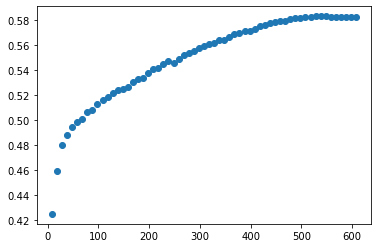

In [12]:
print("Ovisnost dimenzije i točnosti na trening skupu")
plt.scatter(dimenzije, točnost_za_trening)
plt.show()

print("Ovisnost dimenzije i točnosti na testnom skupu")
plt.scatter(dimenzije, točnost_za_testni)
plt.show()

Ovisnost dimenzije i točnosti na testnom skupu


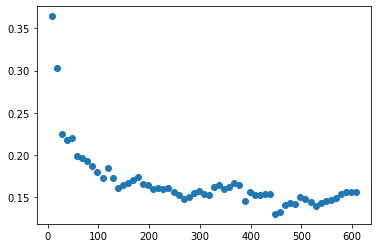

In [13]:
print("Ovisnost dimenzije i točnosti na testnom skupu")
plt.scatter(dimenzije, točnost_za_testni)
plt.show()

### Primjena ICA metode na podatke s 8 klasa

In [109]:
dim2=X1_train.shape[1]
točnost_za_trening2=[]
točnost_za_testni2=[]
dimenzije2=[]
while (dim2>0):
    ICA=impl_ICA()
    ICA2=impl_ICA()
    
    ICA.fit(X1_train,d=dim2)
    ICA2.fit(X1_test,d=dim2)
    
    T=ICA.transform(X1_train)
    Tt=ICA2.transform(X1_test)
    lg12=LogisticRegression(random_state=0,max_iter=6000).fit(T[:,:],y1_train[:T.shape[0]].ravel())
    
    točnost_za_trening2.append(accuracy_score(y1_train[:T.shape[0]],lg12.predict(T)))
    točnost_za_testni2.append(accuracy_score(y1_test[:Tt.shape[0]],lg12.predict(Tt)))
    dimenzije2.append(dim2)
    
    dim2=dim2-100
    


C:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

Ovisnost dimenzije i točnosti na trening skupu


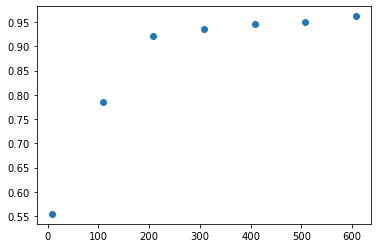

Ovisnost dimenzije i točnosti na testnom skupu


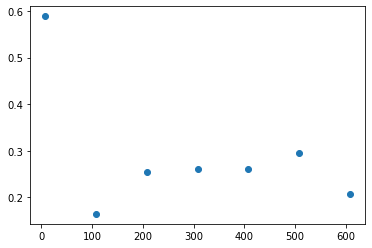

In [110]:
print("Ovisnost dimenzije i točnosti na trening skupu")
plt.scatter(dimenzije2, točnost_za_trening2)
plt.show()

print("Ovisnost dimenzije i točnosti na testnom skupu")
plt.scatter(dimenzije2, točnost_za_testni2)
plt.show()

### Primjena RP metode na podatke s 8 klasa

In [9]:
dim3=X1_train.shape[1]
točnost_za_trening3=[]
točnost_za_testni3=[]
dimenzije3=[]
while (dim3>0):
    RP=impl_RP()
    RP2=impl_RP()
    
    RP.fit(X1_train,d=dim3)
    RP2.fit(X1_test,d=dim3)
    
    T=RP.transform(X1_train)
    Tt=RP2.transform(X1_test)
    lg12=LogisticRegression(random_state=0,max_iter=7000).fit(T[:,:],y1_train.ravel())
    
    točnost_za_trening3.append(accuracy_score(y1_train,lg12.predict(T)))
    točnost_za_testni3.append(accuracy_score(y1_test,lg12.predict(Tt)))
    dimenzije3.append(dim3)
    
    dim3=dim3-10
    


C:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

Ovisnost dimenzije i točnosti na trening skupu


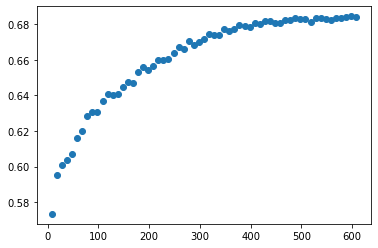

Ovisnost dimenzije i točnosti na testnom skupu


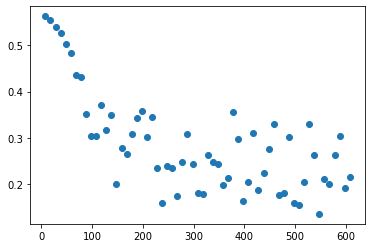

In [10]:
print("Ovisnost dimenzije i točnosti na trening skupu")
plt.scatter(dimenzije3, točnost_za_trening3)
plt.show()

print("Ovisnost dimenzije i točnosti na testnom skupu")
plt.scatter(dimenzije3, točnost_za_testni3)
plt.show()

### Primjena cMDS metode na podatke s 8 klasa

In [11]:
dim4=X1_train.shape[1]-200
točnost_za_trening4=[]
točnost_za_testni4=[]
dimenzije4=[]
while (dim4>0):
    cMDS=impl_cMDS()
    cMDS2=impl_cMDS()
    
    cMDS.fit(pairwise_distances(X1_train),d=dim4)
    cMDS2.fit(pairwise_distances(X1_test),d=dim4)
    
    T=cMDS.transform()
    Tt=cMDS2.transform()
    try:
        lg12=LogisticRegression(random_state=0,max_iter=1000).fit(T[:,:],y1_train.ravel())
    
        točnost_za_trening4.append(accuracy_score(y1_train,lg12.predict(T)))
        točnost_za_testni4.append(accuracy_score(y1_test,lg12.predict(Tt)))
    except:
    dimenzije4.append(dim4)
    
    dim4=dim4-100
    

Ovisnost dimenzije i točnosti na trening skupu


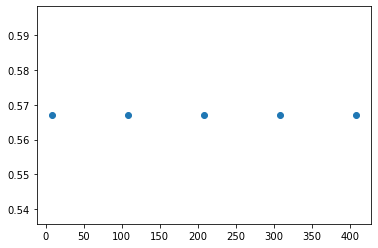

Ovisnost dimenzije i točnosti na testnom skupu


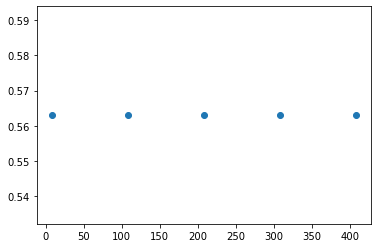

In [12]:
print("Ovisnost dimenzije i točnosti na trening skupu")
plt.scatter(dimenzije4, točnost_za_trening4)
plt.show()

print("Ovisnost dimenzije i točnosti na testnom skupu")
plt.scatter(dimenzije4, točnost_za_testni4)
plt.show()

________________________________________________________________________________________________________

### Primjena PCA metode na podatke s 2 klase, Ambrozija i sve ostalo

In [59]:
pollen_dictionary1={"Alnus Glutin":"Artemisia Vulgaris (FRESH) ",
           "Alnus Glutin (Plair)":"Artemisia Vulgaris (FRESH) ",
            "Ambrosia Artemisifolia (Plair)":"Ambrosia Artemisifolia (Plair)",
            "Ambrosia Artemisifolia 2":"Ambrosia Artemisifolia (Plair)",
            "Artemisia Vulgaris (FRESH) ":"Artemisia Vulgaris (FRESH) ",
            "Artemisia Vulgaris (Plair) ":"Artemisia Vulgaris (FRESH) ",
            "Betula Pendula":"Artemisia Vulgaris (FRESH) ",
            "Betula Pendula (Plair)":"Artemisia Vulgaris (FRESH) ",
            "Cedrus (L. Plair)":"Artemisia Vulgaris (FRESH) ",
            "Cedrus (OCT 2013)":"Artemisia Vulgaris (FRESH) ",
            "Corylus Avelana":"Artemisia Vulgaris (FRESH) ",
            "Corylus Avelana (Plair)":"Artemisia Vulgaris (FRESH) ",
            "Quercus":"Artemisia Vulgaris (FRESH) ",
            "Quercus (Plair)":"Artemisia Vulgaris (FRESH) ",
            "Urtica Diocia":"Artemisia Vulgaris (FRESH) ",
            "Urtica Diocia (Plair)":"Artemisia Vulgaris (FRESH) "
           }


In [60]:
X1 = data.drop(['Pollen Type','Time'], axis=1)
scaler = StandardScaler()
scaler.fit(X1)
X1 = scaler.transform(X1)

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, data[['Pollen Type']], test_size=0.30, random_state=42)

y1_train, y1_test = y1_train.to_numpy(), y1_test.to_numpy()


In [61]:
for i in range(y1_train.shape[0]):
    y1_train[i][0]=pollen_dictionary1[y1_train[i][0]]
    
for i in range(y1_test.shape[0]):
    y1_test[i][0]=pollen_dictionary1[y1_test[i][0]]

In [30]:
dim=X1_train.shape[1]
točnost_za_trening11=[]
točnost_za_testni11=[]

dimenzije=[]

while (dim>0):
    PCA=impl_PCA()
    PCA2=impl_PCA()
    
    PCA.fit(X1_train,k=dim)
    PCA2.fit(X1_test,k=dim)
    
    T=PCA.transform(X1_train)
    Tt=PCA2.transform(X1_test)
    lg12=LogisticRegression(random_state=0,max_iter=4000).fit(T[:,:],y1_train.ravel())
    
    točnost_za_trening11.append(accuracy_score(y1_train,lg12.predict(T)))
    točnost_za_testni11.append(accuracy_score(y1_test,lg12.predict(Tt)))
    dimenzije.append(dim)
    
    dim=dim-50

Ambrozija i sve ostalo - ovisnost dimenzije i točnosti na trening skupu 


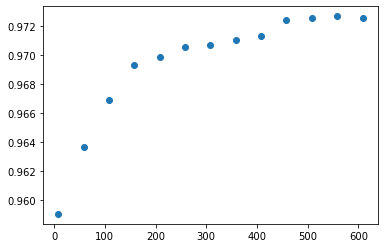

Ambrozija i sve ostalo - ovisnost dimenzije i točnosti na testnom skupu


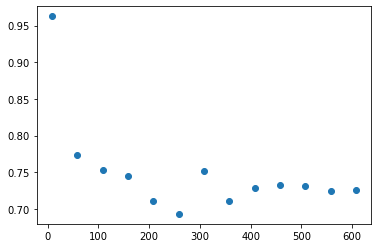

In [31]:
print("Ambrozija i sve ostalo - ovisnost dimenzije i točnosti na trening skupu ")
plt.scatter(dimenzije, točnost_za_trening11)
plt.show()

print("Ambrozija i sve ostalo - ovisnost dimenzije i točnosti na testnom skupu")
plt.scatter(dimenzije, točnost_za_testni11)
plt.show()


### Primjena ICA metode na podatke s 2 klase, Ambrozija i sve ostalo

In [29]:
dim2=X1_train.shape[1]
točnost_za_trening2=[]
točnost_za_testni2=[]
dimenzije2=[]
while (dim2>0):
    ICA=impl_ICA()
    ICA2=impl_ICA()
    
    ICA.fit(X1_train,d=dim2)
    ICA2.fit(X1_test,d=dim2)
    
    T=ICA.transform(X1_train)
    Tt=ICA2.transform(X1_test)
    lg12=LogisticRegression(random_state=0,max_iter=6000).fit(T[:,:],y1_train[:T.shape[0]].ravel())
    
    točnost_za_trening2.append(accuracy_score(y1_train[:T.shape[0]],lg12.predict(T)))
    točnost_za_testni2.append(accuracy_score(y1_test[:Tt.shape[0]],lg12.predict(Tt)))
    dimenzije2.append(dim2)
    
    dim2=dim2-100

Ovisnost dimenzije i točnosti na trening skupu


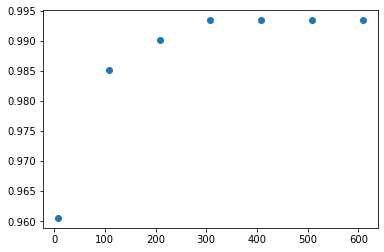

Ovisnost dimenzije i točnosti na testnom skupu


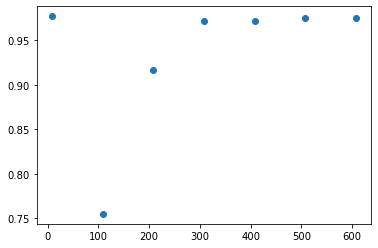

In [32]:
print("Ovisnost dimenzije i točnosti na trening skupu")
plt.scatter(dimenzije2, točnost_za_trening2)
plt.show()

print("Ovisnost dimenzije i točnosti na testnom skupu")
plt.scatter(dimenzije2, točnost_za_testni2)
plt.show()

### Primjena RP metode na podatke s 2 klase, Ambrozija i sve ostalo

In [35]:
dim3=X1_train.shape[1]
točnost_za_trening3=[]
točnost_za_testni3=[]
dimenzije3=[]
while (dim3>0):
    RP=impl_RP()
    RP2=impl_RP()
    
    RP.fit(X1_train,d=dim3)
    RP2.fit(X1_test,d=dim3)
    
    T=RP.transform(X1_train)
    Tt=RP2.transform(X1_test)
    lg12=LogisticRegression(random_state=0,max_iter=4000).fit(T[:,:],y1_train.ravel())
    
    točnost_za_trening3.append(accuracy_score(y1_train,lg12.predict(T)))
    točnost_za_testni3.append(accuracy_score(y1_test,lg12.predict(Tt)))
    dimenzije3.append(dim3)
    
    dim3=dim3-50
    

Ambrozija i sve ostalo - ovisnost dimenzije i točnosti na trening skupu 


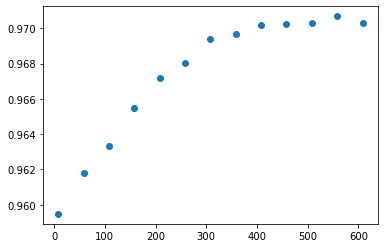

Ambrozija i sve ostalo - ovisnost dimenzije i točnosti na testnom skupu


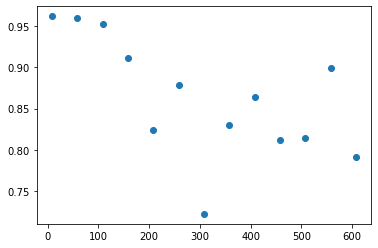

In [36]:
print("Ambrozija i sve ostalo - ovisnost dimenzije i točnosti na trening skupu ")
plt.scatter(dimenzije3, točnost_za_trening3)
plt.show()

print("Ambrozija i sve ostalo - ovisnost dimenzije i točnosti na testnom skupu")
plt.scatter(dimenzije3, točnost_za_testni3)
plt.show()


### Primjena cMDS metode na podatke s 2 klase, Ambrozija i sve ostalo

In [62]:
dim4=X1_train.shape[1]-500
točnost_za_trening4=[]
točnost_za_testni4=[]
dimenzije4=[]
while (dim4>0):
    cMDS=impl_cMDS()
    cMDS2=impl_cMDS()
    
    cMDS.fit(pairwise_distances(X1_train),d=dim4)
    cMDS2.fit(pairwise_distances(X1_test),d=dim4)
    
    T=cMDS.transform()
    Tt=cMDS2.transform()
    lg12=LogisticRegression(random_state=0,max_iter=1000).fit(T[:,:],y1_train.ravel())
    
    točnost_za_trening4.append(accuracy_score(y1_train,lg12.predict(T)))
    točnost_za_testni4.append(accuracy_score(y1_test,lg12.predict(Tt)))
    dimenzije4.append(dim4)
    
    dim4=dim4-100

Ambrozija i ostalo - ovisnost dimenzije i točnosti na trening skupu


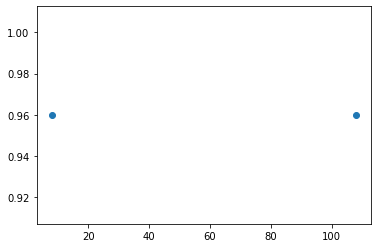

Ambrozija i ostalo - ovisnost dimenzije i točnosti na testnom skupu


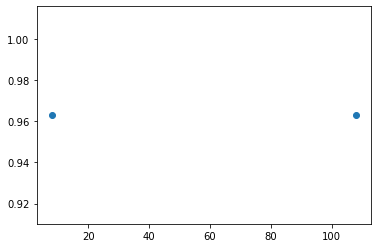

In [63]:
print("Ambrozija i ostalo - ovisnost dimenzije i točnosti na trening skupu")
plt.scatter(dimenzije4, točnost_za_trening4)
plt.show()

print("Ambrozija i ostalo - ovisnost dimenzije i točnosti na testnom skupu")
plt.scatter(dimenzije4, točnost_za_testni4)
plt.show()

_______________________________________________________________________________________________________

### Primjena PCA metode na podatke s 2 klase, Cedrus  i sve ostalo

In [42]:
pollen_dictionary2={"Alnus Glutin":"Artemisia Vulgaris (FRESH) ",
           "Alnus Glutin (Plair)":"Artemisia Vulgaris (FRESH) ",
            "Ambrosia Artemisifolia (Plair)":"Artemisia Vulgaris (FRESH) ",
            "Ambrosia Artemisifolia 2":"Artemisia Vulgaris (FRESH) ",
            "Artemisia Vulgaris (FRESH) ":"Artemisia Vulgaris (FRESH) ",
            "Artemisia Vulgaris (Plair) ":"Artemisia Vulgaris (FRESH) ",
            "Betula Pendula":"Artemisia Vulgaris (FRESH) ",
            "Betula Pendula (Plair)":"Artemisia Vulgaris (FRESH) ",
            "Cedrus (L. Plair)":"Cedrus (OCT 2013)",
            "Cedrus (OCT 2013)":"Cedrus (OCT 2013)",
            "Corylus Avelana":"Artemisia Vulgaris (FRESH) ",
            "Corylus Avelana (Plair)":"Artemisia Vulgaris (FRESH) ",
            "Quercus":"Artemisia Vulgaris (FRESH) ",
            "Quercus (Plair)":"Artemisia Vulgaris (FRESH) ",
            "Urtica Diocia":"Artemisia Vulgaris (FRESH) ",
            "Urtica Diocia (Plair)":"Artemisia Vulgaris (FRESH) "
           }

In [66]:
X1 = data.drop(['Pollen Type','Time'], axis=1)
scaler = StandardScaler()
scaler.fit(X1)
X1 = scaler.transform(X1)

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, data[['Pollen Type']], test_size=0.30, random_state=42)

y1_train, y1_test = y1_train.to_numpy(), y1_test.to_numpy()

In [67]:
for i in range(y1_train.shape[0]):
    y1_train[i][0]=pollen_dictionary2[y1_train[i][0]]
    
for i in range(y1_test.shape[0]):
    y1_test[i][0]=pollen_dictionary2[y1_test[i][0]]

In [47]:
dim=X1_train.shape[1]
točnost_za_trening11=[]
točnost_za_testni11=[]

dimenzije=[]

while (dim>0):
    PCA=impl_PCA()
    PCA2=impl_PCA()
    
    PCA.fit(X1_train,k=dim)
    PCA2.fit(X1_test,k=dim)
    
    T=PCA.transform(X1_train)
    Tt=PCA2.transform(X1_test)
    lg12=LogisticRegression(random_state=0,max_iter=4000).fit(T[:,:],y1_train.ravel())
    
    točnost_za_trening11.append(accuracy_score(y1_train,lg12.predict(T)))
    točnost_za_testni11.append(accuracy_score(y1_test,lg12.predict(Tt)))
    dimenzije.append(dim)
    
    dim=dim-50

Cedrus (OCT 2013) i sve ostalo - ovisnost dimenzije i točnosti na trening skupu 


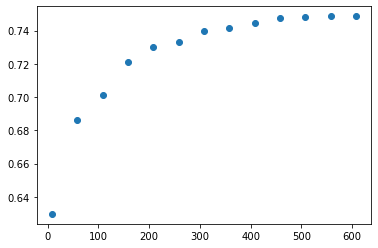

Cedrus (OCT 2013) i sve ostalo - ovisnost dimenzije i točnosti na testnom skupu


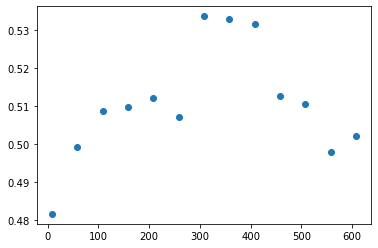

In [48]:
print("Cedrus (OCT 2013) i sve ostalo - ovisnost dimenzije i točnosti na trening skupu ")
plt.scatter(dimenzije, točnost_za_trening11)
plt.show()

print("Cedrus (OCT 2013) i sve ostalo - ovisnost dimenzije i točnosti na testnom skupu")
plt.scatter(dimenzije, točnost_za_testni11)
plt.show()


### Primjena ICA metode na podatke s 2 klase, Cedrus i sve ostalo

In [52]:
dim2=X1_train.shape[1]
točnost_za_trening2=[]
točnost_za_testni2=[]
dimenzije2=[]
while (dim2>0):
    ICA=impl_ICA()
    ICA2=impl_ICA()
    
    ICA.fit(X1_train,d=dim2)
    ICA2.fit(X1_test,d=dim2)
    
    T=ICA.transform(X1_train)
    Tt=ICA2.transform(X1_test)
    lg12=LogisticRegression(random_state=0,max_iter=6000).fit(T[:,:],y1_train[:T.shape[0]].ravel())
    
    točnost_za_trening2.append(accuracy_score(y1_train[:T.shape[0]],lg12.predict(T)))
    točnost_za_testni2.append(accuracy_score(y1_test[:Tt.shape[0]],lg12.predict(Tt)))
    dimenzije2.append(dim2)
    
    dim2=dim2-100

Cedrus (OCT 2013) i sve ostalo - ovisnost dimenzije i točnosti na trening skupu 


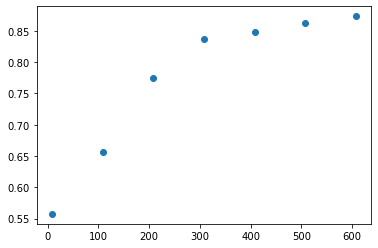

Cedrus (OCT 2013) i sve ostalo - ovisnost dimenzije i točnosti na testnom skupu


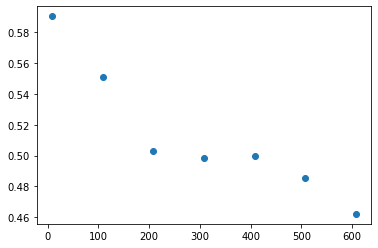

In [56]:
print("Cedrus (OCT 2013) i sve ostalo - ovisnost dimenzije i točnosti na trening skupu ")
plt.scatter(dimenzije2, točnost_za_trening2)
plt.show()

print("Cedrus (OCT 2013) i sve ostalo - ovisnost dimenzije i točnosti na testnom skupu")
plt.scatter(dimenzije2, točnost_za_testni2)
plt.show()


### Primjena RP metode na podatke s 2 klase, Cedrus i sve ostalo

In [57]:
dim3=X1_train.shape[1]
točnost_za_trening3=[]
točnost_za_testni3=[]
dimenzije3=[]
while (dim3>0):
    RP=impl_RP()
    RP2=impl_RP()
    
    RP.fit(X1_train,d=dim3)
    RP2.fit(X1_test,d=dim3)
    
    T=RP.transform(X1_train)
    Tt=RP2.transform(X1_test)
    lg12=LogisticRegression(random_state=0,max_iter=4000).fit(T[:,:],y1_train.ravel())
    
    točnost_za_trening3.append(accuracy_score(y1_train,lg12.predict(T)))
    točnost_za_testni3.append(accuracy_score(y1_test,lg12.predict(Tt)))
    dimenzije3.append(dim3)
    
    dim3=dim3-50


Cedrus (OCT 2013) i sve ostalo - ovisnost dimenzije i točnosti na trening skupu 


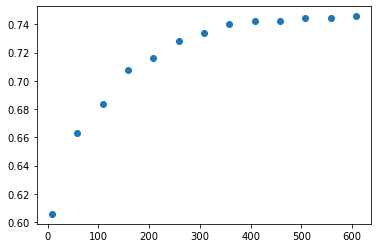

Cedrus (OCT 2013) i sve ostalo - ovisnost dimenzije i točnosti na testnom skupu


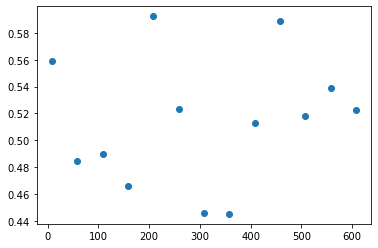

In [58]:
print("Cedrus (OCT 2013) i sve ostalo - ovisnost dimenzije i točnosti na trening skupu ")
plt.scatter(dimenzije3, točnost_za_trening3)
plt.show()

print("Cedrus (OCT 2013) i sve ostalo - ovisnost dimenzije i točnosti na testnom skupu")
plt.scatter(dimenzije3, točnost_za_testni3)
plt.show()


### Primjena cMDS metode na podatke s 2 klase, Cedrud i sve ostalo

In [68]:
dim4=X1_train.shape[1]-400
točnost_za_trening4=[]
točnost_za_testni4=[]
dimenzije4=[]
while (dim4>0):
    cMDS=impl_cMDS()
    cMDS2=impl_cMDS()
    
    cMDS.fit(pairwise_distances(X1_train),d=dim4)
    cMDS2.fit(pairwise_distances(X1_test),d=dim4)
    
    T=cMDS.transform()
    Tt=cMDS2.transform()
    lg12=LogisticRegression(random_state=0,max_iter=1000).fit(T[:,:],y1_train.ravel())
    
    točnost_za_trening4.append(accuracy_score(y1_train,lg12.predict(T)))
    točnost_za_testni4.append(accuracy_score(y1_test,lg12.predict(Tt)))
    dimenzije4.append(dim4)
    
    dim4=dim4-100

Cedrus (OCT 2013) i sve ostalo - ovisnost dimenzije i točnosti na trening skupu 


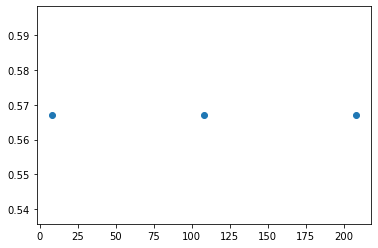

Cedrus (OCT 2013) i sve ostalo - ovisnost dimenzije i točnosti na testnom skupu


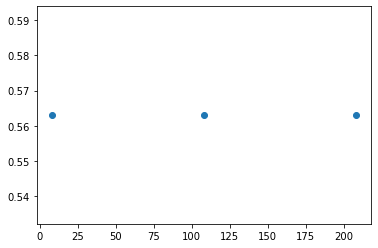

In [69]:
print("Cedrus (OCT 2013) i sve ostalo - ovisnost dimenzije i točnosti na trening skupu ")
plt.scatter(dimenzije4, točnost_za_trening4)
plt.show()

print("Cedrus (OCT 2013) i sve ostalo - ovisnost dimenzije i točnosti na testnom skupu")
plt.scatter(dimenzije4, točnost_za_testni4)
plt.show()